In [1]:
from texture_color_segmentation.feature_extraction import feature_extractor
from texture_color_segmentation.distance_regularized_level_set_evolution.drlse_algo import drlse_edge
from texture_color_segmentation.distance_regularized_level_set_evolution.potential_func import DOUBLE_WELL
import matplotlib.pyplot as plt
from skimage import measure
import numpy as np
import cv2

In [2]:
def plot_features(features):
    for i in range(features.shape[3]):
        for j in range(features.shape[2]):
            plt.subplot(features.shape[3],features.shape[2],(i*features.shape[2])+j+1)
            plt.imshow(features[:,:,j,i])
    plt.show()

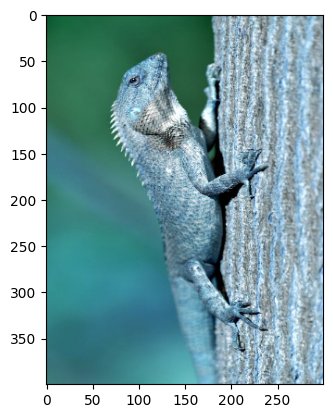

In [3]:
image_path = "samples/lizard.jpeg"

image = cv2.imread(image_path)
image = cv2.resize(image, (300,400))

plt.imshow(image)
plt.show()

In [4]:
import pickle
filename = f"data/extractor_{image_path[image_path.rindex('/')+1:image_path.rindex('.')]}.pkl"

feature_methods = ["contrast", "energy"]

window_size=27
feature_methods = ['contrast', 'cluster prominence', 'energy', 'dissimilarity', 'homogeneity', 'correlation']
extractor = feature_extractor(image, window_size, feature_methods=feature_methods)

# with open(filename, 'rb') as file:
#     extractor = pickle.load(file)

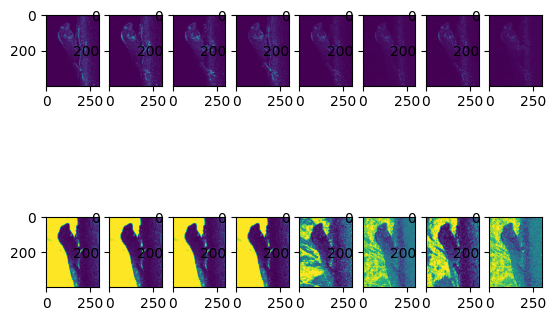

In [5]:
texture_features = extractor.get_texture_features()

plot_features(texture_features)

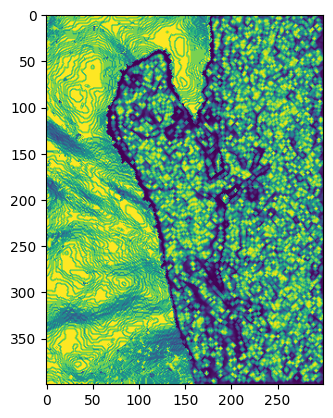

In [10]:
g_combined = extractor.get_combined_edges(sigma_structuring_element=0.5)

plt.imshow(g_combined)
plt.show()

In [7]:
with open(filename, 'wb') as file:
    pickle.dump(extractor, file)

In [11]:
c0 = 2
initial_lsf = c0 * np.ones_like(g_combined)
initial_lsf[10:, 10:-10] = -c0

In [14]:
iteration = 0
phi = initial_lsf.copy()
last_title = ""
cv2.imshow(last_title, image)

while True:    
    contours = measure.find_contours(phi, 0)

    contour_image = image.copy()
    cv_contours = []
    for contour in contours:
        cv_contour = np.array([[int(point[1]), int(point[0])] for point in contour], dtype=np.int32)
        cv_contours.append(cv_contour)
    cv2.drawContours(contour_image, cv_contours, -1, (0, 0, 255), 2)

    if not cv2.getWindowProperty(last_title, cv2.WND_PROP_VISIBLE): break # Stop when window was closed

    cv2.imshow(last_title, contour_image)

    new_title = f"DRLSE iteration {iteration}"
    cv2.setWindowTitle(last_title, new_title)
    last_tile = new_title

    if cv2.waitKey(1) != -1: break # Stop when key was pressed
    
    timestep = 5
    phi = drlse_edge(
        phi_0=phi,
        g=g_combined,
        mu=0.2/timestep,
        timestep=timestep,
        iters=1,
        lmda=5,
        alfa=2,
        epsilon=1.5,
        potential_function=DOUBLE_WELL)
    
    iteration += 1
cv2.destroyAllWindows()

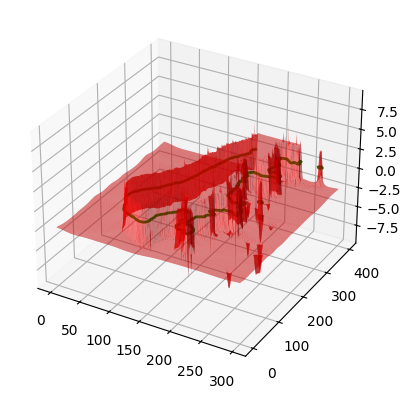

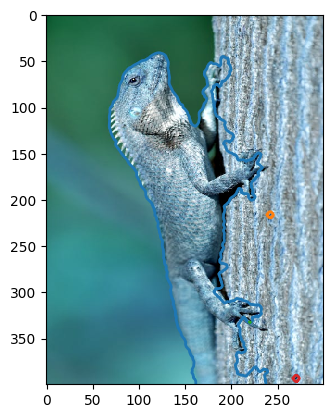

In [15]:
plt.ion()
fig1 = plt.figure(1)
fig2 = plt.figure(2)


fig1.clf()
ax1 = fig1.add_subplot(111, projection='3d')
y, x = phi.shape
x = np.arange(0, x, 1)
y = np.arange(0, y, 1)
X, Y = np.meshgrid(x, y)
ax1.plot_surface(X, Y, -phi, rstride=2, cstride=2, color='r', linewidth=0, alpha=0.6, antialiased=True)
ax1.contour(X, Y, phi, 0, colors='g', linewidths=2)

fig2.clf()
contours = measure.find_contours(phi, 0)

ax2 = fig2.add_subplot(111)
ax2.imshow(image, interpolation='nearest', cmap=plt.get_cmap('gray'))
for contour in contours:
    ax2.plot(contour[:, 1], contour[:, 0], linewidth=2)

In [16]:
from texture_color_segmentation.feature_extraction import utils
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('input.mp4', fourcc, 20.0, (image.shape[1], image.shape[0]))

total_frames = 100
for i in range(total_frames):
    
    edges = extractor.get_combined_edges(homogeneity_threhold=i/total_frames)

    frame = cv2.applyColorMap(cv2.cvtColor((utils.normalize(edges)*256).astype(np.uint8), cv2.COLOR_GRAY2BGR), cv2.COLORMAP_VIRIDIS)
    out.write(frame)

out.release()